# Advanced Computer Vision for AI - Group Assignment

In [1]:
import cv2
import os
import time
import numpy as np
from imutils.video import VideoStream

from PIL import Image
import torch
import torchvision
import torchvision.transforms as T

import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings("ignore")

## Task 2 - Background Detection

In [2]:
def detect_background(file, plot):
    """Extracts background from a video and saves it to a jpg file"""

    filename = file.replace(".mp4","")+"_background.jpg"
    vid = cv2.VideoCapture(file) 
    subtractor = cv2.createBackgroundSubtractorMOG2()

    bg_frames = []
    i = 0

    ret, frame = vid.read()
    while(ret):
        mask = subtractor.apply(frame)
        mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
        mask = cv2.bitwise_not(mask) #To change background to white

        combined = cv2.bitwise_and(frame, mask)
        bg_frames.append(combined)

        i+=1
        ret, frame = vid.read()
        if i == 500:
            break

    vid.release()
    medianFrame = np.median(bg_frames, axis=0).astype(dtype=np.uint8)
    cv2.imwrite(filename, medianFrame)

    if plot:
        plt.imshow(medianFrame)
        plt.show()


The above function was used to find and extract the backgrounds of each of the videos in our dataset.

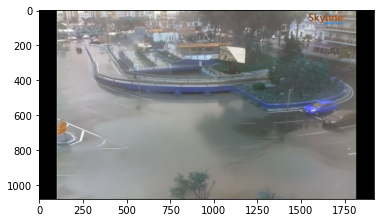

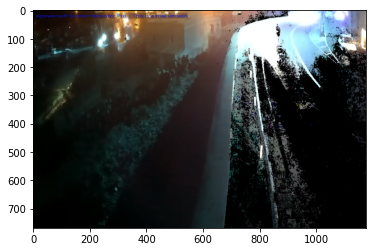

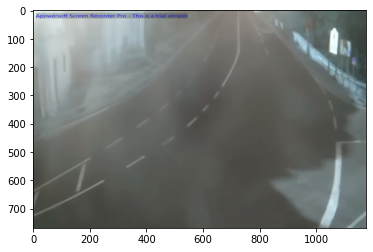

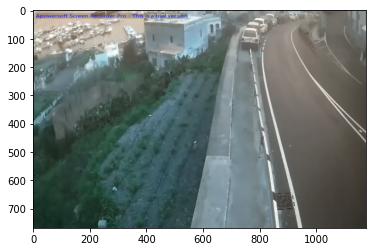

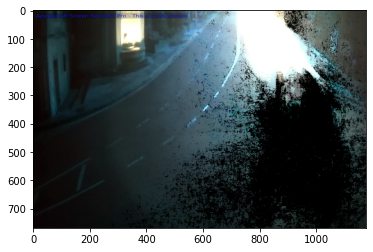

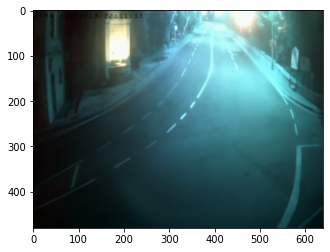

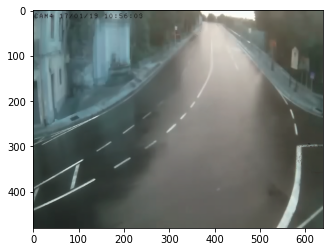

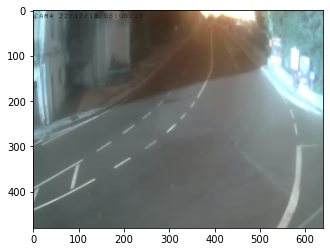

In [36]:
viddirpath = os.path.join(os.path.dirname(os.getcwd()), "Videos")

detect_background("Videos/075607.mp4", True)
detect_background("Videos/075812.mp4", False)
detect_background("Videos/124215.mp4", False)
detect_background("Videos/155250.mp4", False)
detect_background("Videos/160440.mp4", False)
detect_background("Videos/161152.mp4", False)
detect_background("Videos/190010.mp4", False)
detect_background("Videos/20190127_200452.mp4", True)
detect_background("Videos/20190127_201057.mp4", False)
detect_background("Videos/20190128_065933.mp4", False)
detect_background("Videos/footage2.mp4", True)
detect_background("Videos/footage3.mp4", True)
detect_background("Videos/nightfootage2.mp4", True)
detect_background("Videos/nightTest.mp4", True)
detect_background("Videos/rainTest.mp4", True)
detect_background("Videos/Video 1.mp4", True)
detect_background("Videos/Video 2 and sunnyTest.mp4", False)
detect_background("Videos/Video 3.mp4", False)
detect_background("Videos/Video 4.mp4", False)

## Task 3 - Object Detection with Trained Model

In [3]:
def trained_object_detection_video(filename, background_boxes, conf_t=0.5, thresh=0.3, fr_limit=500):
    labelspath = os.path.join(os.path.dirname(os.getcwd()), "Trained", "obj.names")
    LABELS = open(labelspath).read().strip().split("\n")

    COLOURS = np.random.uniform(0, 255, size=(len(LABELS), 3))

    fourcc = cv2.VideoWriter_fourcc(*"MJPG")
    writer = cv2.VideoWriter('output/objectdetection_ours.avi', fourcc, 30, (800, 600), True)

    vid = cv2.VideoCapture(filename)
    ret = True
    
    fr_no = 0
    
    start = time.time()
    
    # load our serialized model from disk
    print("[INFO] loading model...")

    while(ret):
        ret, frame = vid.read()
        if not ret:
            break
                
                
        frame, _ = trained_object_detection(frame, background_boxes,colours=COLOURS)
        
        writer.write(cv2.resize(frame,(800, 600)))
        
        if fr_no >= fr_limit:
            break
        
        # if fr_no%200 == 0:
        #     print(fr_no)
        
        fr_no += 1
        
    
    print("[INFO] YOLO took {:.2f} minutes".format((time.time() - start)/60))
    
    writer.release()
    vid.release()

In [7]:
def trained_object_detection(frame, background_boxes=None, colours=None,conf_t=0.5, thresh=0.3):
    labelspath = os.path.join(os.path.dirname(os.getcwd()), "Trained", "obj.names")
    configpath = os.path.join(os.path.dirname(os.getcwd()), "Trained", "yolov4-custom.cfg")
    weightspath = os.path.join(os.path.dirname(os.getcwd()), "Trained", "yolov4-custom_best_5200.weights")
    
    LABELS = open(labelspath).read().strip().split("\n")

    if colours is None:
        COLORS = np.random.uniform(0, 255, size=(len(LABELS), 3))
    else:
        COLORS = colours

    net = cv2.dnn.readNetFromDarknet(configpath, weightspath)
    
    (H, W) = frame.shape[:2]
    # determine only the *output* layer names that we need from YOLO
    ln = net.getLayerNames()
    ln = [ln[i - 1] for i in net.getUnconnectedOutLayers()]
    # construct a blob from the input image and then perform a forward
    # pass of the YOLO object detector, giving us our bounding boxes and
    # associated probabilities
    blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    layerOutputs = net.forward(ln)

    # initialize our lists of detected bounding boxes, confidences, and
    # class IDs, respectively
    boxes = []
    confidences = []
    classIDs = []

        # loop over each of the layer outputs
    for output in layerOutputs:
        # loop over each of the detections
        for detection in output:
            # extract the class ID and confidence (i.e., probability) of
            # the current object detection
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]
            # filter out weak predictions by ensuring the detected
            # probability is greater than the minimum probability
            if confidence > conf_t:
                # scale the bounding box coordinates back relative to the
                # size of the image, keeping in mind that YOLO actually
                # returns the center (x, y)-coordinates of the bounding
                # box followed by the boxes' width and height
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")
                # use the center (x, y)-coordinates to derive the top and
                # and left corner of the bounding box
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))
                # update our list of bounding box coordinates, confidences,
                # and class IDs
                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)
                
    # apply non-maxima suppression to suppress weak, overlapping bounding
    # boxes
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, conf_t, thresh)
            
    back_boxes = []
    # ensure at least one detection exists
    if len(idxs) > 0:
        # loop over the indexes we are keeping
        for i in idxs.flatten():
            b_check = False
            # extract the bounding box coordinates
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])
            
            if background_boxes is not None:
                for bx, by in background_boxes:
                    if abs(bx - x) <= 10 and abs(by - y) <= 10:
                        b_check = True
                        continue
            if b_check:
                continue
            # draw a bounding box rectangle and label on the image
            color = [int(c) for c in COLORS[classIDs[i]]]
            cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
            text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
            cv2.putText(frame, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,
                0.5, color, 2)
            
            back_boxes.append([x, y])
        
    return frame, back_boxes

### Object Detection on Background Only

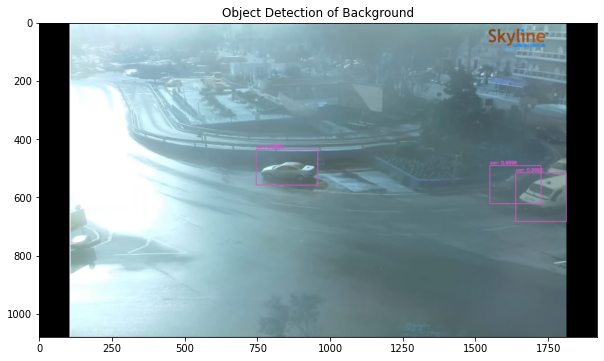

In [8]:
background = cv2.imread("075812_background.jpg")

object_detected_back, back_obj_boxes = trained_object_detection(background)

plt.figure(figsize=(10,10))
plt.imshow(object_detected_back)
plt.title("Object Detection of Background")
plt.show()

### Object Detection on Foreground Only

In [10]:
path_to_file = os.path.join(os.path.dirname(os.getcwd()), "Videos")
filename = "075812.mp4"

trained_object_detection_video(os.path.join(path_to_file, filename), back_obj_boxes, fr_limit=3000)

[INFO] loading model...
[INFO] YOLO took 90.02 minutes


## Task 4 - Compare Object Detection Techniques

### Faster R-CNN (Deep CV)

In [ ]:
# get the pretrained model from torchvision.models
# Note: pretrained=True will get the pretrained weights for the model.
# model.eval() to use the model for inference
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Class labels from official PyTorch documentation for the pretrained model
# Note that there are some N/A's
# for complete list check https://tech.amikelive.com/node-718/what-object-categories-labels-are-in-coco-dataset/
# we will use the same list for this notebook
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [ ]:
def get_prediction(img_cv, threshold):
    """
        get_prediction
        parameters:
        - img_path - path of the input image
        - threshold - threshold value for prediction score
        method:
        - Image is obtained from the image path
        - the image is converted to image tensor using PyTorch's Transforms
        - image is passed through the model to get the predictions
        - class, box coordinates are obtained, but only prediction score > threshold
        are chosen.
    """
    transform = T.Compose([T.ToTensor()])
    img = transform(img_cv)
    pred = model([img])
    pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
    pred_score = list(pred[0]['scores'].detach().numpy())
    print("iteration")
    pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1]
    pred_boxes = pred_boxes[:pred_t + 1]
    pred_class = pred_class[:pred_t + 1]
    return pred_boxes, pred_class

In [ ]:
def faster_object_detection(vid_path, threshold=0.7, rect_th=2, text_size=0.5, text_th=2, fr_limit=500):
    """
    object_detection_api
    parameters:
        - img_path - path of the input image
        - threshold - threshold value for prediction score
        - rect_th - thickness of bounding box
        - text_size - size of the class label text
        - text_th - thichness of the text
    method:
        - prediction is obtained from get_prediction method
        - for each prediction, bounding box is drawn and text is written
        with opencv
        - the final image is displayed
    """
    fourcc = cv2.VideoWriter_fourcc(*"MJPG")
    writer = cv2.VideoWriter('output/objectdetection_faster_rcnn.avi', fourcc, 30, (800, 600), True)

    # image = cv2.imread(args["image"])
    vid = cv2.VideoCapture(vid_path)
    ret = True

    fr_no = 0

    start = time.time()
    print("[INFO] Started video processing...")

    while (ret):

        ret, frame = vid.read()
        if not ret:
            print("Error")

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        boxes, pred_cls = get_prediction(Image.fromarray(frame), threshold)
        color_index = set(pred_cls)
        COLORS = np.random.uniform(0, 255, size=(len(color_index), 3))

        for i in range(len(boxes)):
            pt1 = (int(boxes[i][0][0]), int(boxes[i][0][1]))
            pt2 = (int(boxes[i][1][0]), int(boxes[i][1][1]))
            cv2.rectangle(frame, pt1, pt2, color=list(color_index).index(pred_cls[i]), thickness=rect_th)
            cv2.putText(frame, pred_cls[i], pt1, cv2.FONT_HERSHEY_SIMPLEX, text_size,
                        list(color_index).index(pred_cls[i]), thickness=text_th)

        if fr_no % 100 == 0:
            print(fr_no)

        if fr_no >= fr_limit:
            break

        fr_no += 1

    print("[INFO] FasterRCNN took {:.3f} minutes".format((time.time() - start) / 60))

    writer.release()
    vid.release()

### YoloV3 (Deep CV)

In [ ]:
def yolo_object_detection(filename, conf_t=0.5, thresh=0.3, fr_limit=300):
    labelspath = "YOLO Model/darknet/coco.names"
    configpath = "YOLO Model/darknet/yolov3-320.cfg"
    weightspath = "YOLO Model/darknet/yolov3-320.weights"

    LABELS = open(labelspath).read().strip().split("\n")

    COLORS = np.random.uniform(0, 255, size=(len(LABELS), 3))

    # load our serialized model from disk
    print("[INFO] loading model...")
    net = cv2.dnn.readNetFromDarknet(configpath, weightspath)

    fourcc = cv2.VideoWriter_fourcc(*"MJPG")
    writer = cv2.VideoWriter('output/objectdetection_yolo.avi', fourcc, 30, (800, 600), True)

    vid = cv2.VideoCapture(filename)
    ret = True

    fr_no = 0

    start = time.time()

    while (ret):
        ret, frame = vid.read()
        if not ret:
            print("Error")

        (H, W) = frame.shape[:2]
        # determine only the *output* layer names that we need from YOLO
        ln = net.getLayerNames()
        ln = [ln[i - 1] for i in net.getUnconnectedOutLayers()]

        # construct a blob from the input image and then perform a forward
        # pass of the YOLO object detector, giving us our bounding boxes and
        # associated probabilities
        blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (416, 416), swapRB=True, crop=False)
        net.setInput(blob)
        layerOutputs = net.forward(ln)

        # initialize our lists of detected bounding boxes, confidences, and
        # class IDs, respectively
        boxes = []
        confidences = []
        classIDs = []

        # loop over each of the layer outputs
        for output in layerOutputs:
            # loop over each of the detections
            for detection in output:
                # extract the class ID and confidence (i.e., probability) of
                # the current object detection
                scores = detection[5:]
                classID = np.argmax(scores)
                confidence = scores[classID]
                # filter out weak predictions by ensuring the detected
                # probability is greater than the minimum probability
                if confidence > conf_t:
                    # scale the bounding box coordinates back relative to the
                    # size of the image, keeping in mind that YOLO actually
                    # returns the center (x, y)-coordinates of the bounding
                    # box followed by the boxes' width and height
                    box = detection[0:4] * np.array([W, H, W, H])
                    (centerX, centerY, width, height) = box.astype("int")
                    # use the center (x, y)-coordinates to derive the top and
                    # and left corner of the bounding box
                    x = int(centerX - (width / 2))
                    y = int(centerY - (height / 2))
                    # update our list of bounding box coordinates, confidences,
                    # and class IDs
                    boxes.append([x, y, int(width), int(height)])

                    confidences.append(float(confidence))
                    classIDs.append(classID)

                # apply non-maxima suppression to suppress weak, overlapping bounding
        # boxes
        idxs = cv2.dnn.NMSBoxes(boxes, confidences, conf_t, thresh)

        # ensure at least one detection exists
        if len(idxs) > 0:
            # loop over the indexes we are keeping
            for i in idxs.flatten():
                # extract the bounding box coordinates
                (x, y) = (boxes[i][0], boxes[i][1])
                (w, h) = (boxes[i][2], boxes[i][3])
                # draw a bounding box rectangle and label on the image
                color = [int(c) for c in COLORS[classIDs[i]]]
                cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
                text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
                cv2.putText(frame, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,
                            0.5, color, 2)

        writer.write(cv2.resize(frame, (800, 600)))

        if fr_no >= fr_limit:
            break

        fr_no += 1

    print("[INFO] YOLO took {:.3f} minutes".format((time.time() - start) / 60))

    writer.release()
    vid.release()

### HOG-SVM (Machine Learning)

##### Training SVM

In [ ]:
#Converts Image Colour for Formatting
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2Lab':
        return cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

In [ ]:
# HOG features of image
def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=False,
                                  visualize=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=False,
                       visualize=vis, feature_vector=feature_vec)
        return features

In [ ]:
# Spatial features of image
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

In [ ]:
# Hist features of image
def color_hist(img, nbins=32, hist_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=hist_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=hist_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=hist_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [ ]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        #image *= 255.0
        #image = image.astype(np.uint8)

        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'RGB2HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'RGB2LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'RGB2HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'RGB2YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'RGB2YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
            elif color_space == 'RGB2Lab':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2Lab)
        else: feature_image = np.copy(image)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins, hist_range=hist_range)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel],
                                        orient, pix_per_cell, cell_per_block,
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

##### Import Training Dataset

In [ ]:
vehicles = glob.glob('F:/data/vehicles/*.png')
nonvehicles = glob.glob('F:/data/non-vehicles/*.png')

# print("Number of Vehicles in Dataset: ", len(vehicles))
# print("Number of Non-Vehicles in Dataset:",len(nonvehicles))

##### SVM Parameters

In [ ]:
color_space = 'RGB2YCrCb' # Can be RGB, RGB2HSV, RGB2LUV, RGB2HLS, RGB2YUV, RGB2YCrCb, RGB2Lab
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions, rank: 32 >= 16
hist_bins = 64    # Number of histogram bins
hist_range=(0, 256)
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

In [ ]:
features_v = extract_features(vehicles, color_space=color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins,
                        orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=spatial_feat,
                        hist_feat=hist_feat, hog_feat=hog_feat)

features_nv = extract_features(nonvehicles, color_space=color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins,
                        orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=spatial_feat,
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((features_v, features_nv)).astype(np.float64)

X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(features_v)), np.zeros(len(features_nv))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:', orient, 'orientations', pix_per_cell, 'pixels per cell and', cell_per_block, 'cells per block')
print('Feature vector length:', len(X_train[0]))

svc = LinearSVC()
start = time.time()

svc.fit(X_train, y_train)
end = time.time()
print(round(end-start, 2), 'Seconds to train SVC...')

print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
t = time.time()

##### Training for Vehicle Detection

In [ ]:
# Extracts features and detects vehicles in a given image.
# Returns windows containing possible detections.
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,
              color_space='RGB2YCrCb'):
    img_tosearch = img[ystart:ystop, :, :]
    ctrans_tosearch = convert_color(img_tosearch, conv=color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))

    ch1 = ctrans_tosearch[:, :, 0]
    ch2 = ctrans_tosearch[:, :, 1]
    ch3 = ctrans_tosearch[:, :, 2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1
    nfeat_per_block = orient * cell_per_block ** 2

    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = ((nxblocks - nblocks_per_window) // cells_per_step) + 1
    nysteps = ((nyblocks - nblocks_per_window) // cells_per_step) + 1

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    hot_windows = []

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop + window, xleft:xleft + window], (64, 64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(
                np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            # test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))
            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                win_draw = np.int(window * scale)
                hot_windows.append(
                    ((xbox_left, ytop_draw + ystart), (xbox_left + win_draw, ytop_draw + win_draw + ystart)))

    return hot_windows

In [ ]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=2):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


def add_heat(heatmap, bbox_list, value=1):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += value

    # Return updated heatmap
    return heatmap


def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1] + 1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 255), 6)
        cv2.putText(img, 'Vehicles Detected: '+ str(car_number), (50,50), cv2.FONT_HERSHEY_COMPLEX, 0.5, color=(255,0,0), thickness=2)
    # Return the image
    return img

##### Testing HOG

In [ ]:
all_ystart = (360, 360, 360, 360)
all_ystop = (660, 660, 660, 660)
all_scales = (0.9, 1.1, 1.4, 1.7)

original_image = mpimg.imread('test.jpg')
image = original_image.astype(np.float32)/255.0

all_hot_windows = []
for ystart, ystop, scale in zip(all_ystart, all_ystop, all_scales):
    all_hot_windows += find_cars(image, ystart, ystop, scale, svc, 
                                 X_scaler, orient, pix_per_cell, 
                                 cell_per_block, spatial_size, 
                                 hist_bins, color_space)

out_image = draw_boxes(original_image, all_hot_windows)

heat = np.zeros_like(original_image[:,:,0]).astype(np.float)
# Add heat to each box in box list
heat = add_heat(heat, all_hot_windows)
# Apply threshold to help remove false positives
heat = apply_threshold(heat, 1)
# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)
# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(original_image), labels)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
ax1.imshow(out_image)
ax1.set_title('Car Positions for test.jpg', fontsize=16)
ax2.imshow(heatmap, cmap='hot')
ax2.set_title('Heat Map', fontsize=16)
f.tight_layout()

##### Video Processing

In [ ]:
def process_frame(original_image, heat_thresh=1, heat_queue = deque(maxlen=25), frlimit = 500):
    
    # Scale image from 0 to 1
    image = original_image.astype(np.float32)/255.0

        # Perform HOG subsampling as multiple scales
    all_ystart = (360, 360, 360, 360)
    all_ystop = (660, 660, 660, 660)
    all_scales = (0.9, 1.1, 1.4, 1.7)
    all_hot_windows = []
    for ystart, ystop, scale in zip(all_ystart, all_ystop, all_scales):
        all_hot_windows += find_cars(image, ystart, ystop, scale, svc, 
                                         X_scaler, orient, pix_per_cell, 
                                         cell_per_block, spatial_size, 
                                         hist_bins, color_space)


    heat = np.zeros_like(original_image[:,:,0]).astype(np.float)
        # Add heat to each box in box list
    heat = add_heat(heat, all_hot_windows)
        #print('heat max 1:', np.max(heat))

        # Add heat to circular buffer and find total
    heat_queue.append(heat)
    total_heat = np.sum(heat_queue, axis=0).astype(np.uint8)
        # Apply threshold to help remove false positives
    total_heat = apply_threshold(total_heat, heat_thresh)   
    heatmap = np.clip(total_heat, 0, 255)
        # Find final boxes from heatmap using label function
    labels = label(heatmap)

    out_image = draw_boxes(original_image, all_hot_windows)
    
    return draw_labeled_bboxes(np.copy(out_image), labels)

In [ ]:
input_video = 'E:/vehicle-detection-classification-opencv/CV Vids/20200327_160440.mp4'
output_video = 'sunny_hog.mp4'
clip = VideoFileClip(input_video)
processed = clip.fl_image(process_frame)
%time processed.write_videofile(output_video, audio=False)

## Task 5 - Car Counting

In [ ]:
def car_counting(filename, conf_t=0.5, thresh=0.3, fr_limit=300):
    labelspath = "YOLO Model/darknet/coco.names"
    configpath = "YOLO Model/darknet/yolov3-320.cfg"
    weightspath = "YOLO Model/darknet/yolov3-320.weights"

    LABELS = open(labelspath).read().strip().split("\n")

    COLORS = np.random.uniform(0, 255, size=(len(LABELS), 3))

    # load our serialized model from disk
    print("[INFO] loading model...")
    net = cv2.dnn.readNetFromDarknet(configpath, weightspath)

    fourcc = cv2.VideoWriter_fourcc(*"MJPG")
    writer = cv2.VideoWriter('output/sunny_objectdetection_yolo.avi', fourcc, 30, (800, 600), True)

    vid = cv2.VideoCapture(filename)
    ret = True

    fr_no = 0

    start = time.time()

    while (ret):
        ret, frame = vid.read()
        if not ret:
            print("Error")

        (H, W) = frame.shape[:2]
        # determine only the *output* layer names that we need from YOLO
        ln = net.getLayerNames()
        ln = [ln[i - 1] for i in net.getUnconnectedOutLayers()]

        # construct a blob from the input image and then perform a forward
        # pass of the YOLO object detector, giving us our bounding boxes and
        # associated probabilities
        blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (416, 416), swapRB=True, crop=False)
        net.setInput(blob)
        layerOutputs = net.forward(ln)

        # initialize our lists of detected bounding boxes, confidences, and
        # class IDs, respectively
        boxes = []
        confidences = []
        classIDs = []

        # loop over each of the layer outputs
        for output in layerOutputs:
            # loop over each of the detections
            for detection in output:
                # extract the class ID and confidence (i.e., probability) of
                # the current object detection
                scores = detection[5:]
                classID = np.argmax(scores)
                confidence = scores[classID]
                # filter out weak predictions by ensuring the detected
                # probability is greater than the minimum probability
                if confidence > conf_t:
                    # scale the bounding box coordinates back relative to the
                    # size of the image, keeping in mind that YOLO actually
                    # returns the center (x, y)-coordinates of the bounding
                    # box followed by the boxes' width and height
                    box = detection[0:4] * np.array([W, H, W, H])
                    (centerX, centerY, width, height) = box.astype("int")
                    # use the center (x, y)-coordinates to derive the top and
                    # and left corner of the bounding box
                    x = int(centerX - (width / 2))
                    y = int(centerY - (height / 2))
                    # update our list of bounding box coordinates, confidences,
                    # and class IDs
                    boxes.append([x, y, int(width), int(height)])

                    confidences.append(float(confidence))
                    classIDs.append(classID)

                # apply non-maxima suppression to suppress weak, overlapping bounding
        # boxes
        idxs = cv2.dnn.NMSBoxes(boxes, confidences, conf_t, thresh)

        LS = []
        # ensure at least one detection exists
        if len(idxs) > 0:
            car_counter = 0
            motorbike_counter = 0
            # loop over the indexes we are keeping
            for i in idxs.flatten():
                # extract the bounding box coordinates
                (x, y) = (boxes[i][0], boxes[i][1])
                (w, h) = (boxes[i][2], boxes[i][3])

                # draw a bounding box rectangle and label on the image
                color = [int(c) for c in COLORS[classIDs[i]]]
                cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
                text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
                cv2.putText(frame, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,
                            0.5, color, 2)
                if LABELS[classIDs[i]] in class_dict.keys():
                    L = [str(class_dict[LABELS[classIDs[i]]]), str(confidences[i]), str(x / W), str(y / H), str(w / W),
                         str(h / H)]
                    LS.append(" ".join(L))

                if LABELS[classIDs[i]] == 'car':
                    car_counter += 1
                elif LABELS[classIDs[i]] == 'motorbike':
                    motorbike_counter += 1

                cv2.putText(frame, 'Cars Detected: ' + str(car_counter), (50, 50), cv2.FONT_HERSHEY_COMPLEX, 0.5,
                            color=(255, 0, 0), thickness=2)
                cv2.putText(frame, 'Motorbikes Detected: ' + str(motorbike_counter), (50, 70), cv2.FONT_HERSHEY_COMPLEX, 0.5,
                            color=(255, 0, 0), thickness=2)

        writer.write(cv2.resize(frame, (800, 600)))

        output_txt = open("Predicted_Anns_YOLO/footage2/" + str(fr_no + 1).zfill(4) + ".txt", "w")
        if len(LS) > 0:
            output_txt.write("\n".join(LS))
        else:
            output_txt.write("")
        output_txt.close()

        if fr_no >= fr_limit:
            break

        fr_no += 1

    print("[INFO] YOLO took {:.3f} minutes".format((time.time() - start) / 60))

    writer.release()
    vid.release()